__Warning__
********************************

_LSFMs only evaluate SFs for a fixed target policy that selects actions uni-formly at random.  The learned model can then be used to predict the valuefunction of any arbitrary policy, including the optimal policy._

_LSFMs do not include a value prediction module_

_test different alpha for the loss_ : results : alpha_N = 1.0 / alpha_psi = 0.01

*********************************

__BUGS__
Attention : ne pas faire de _reset_LSFM_ : probleme d'allocation de nouveau tenseur je pense

# Environment

In [1]:
import gym
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import layers, Input


import random
import numpy as np
import datetime as dt
import math

import pandas as pd
import seaborn as sns
sns.set()


import matplotlib.pyplot as plt
from gridworld import SimpleGrid


In [2]:


class custom_env:

    def __init__(self, env_name, param={}):
        # Initialize atributes
        self.env_name = env_name    # name of environment
        self.param = param          # dictionarry of environment parameters

        if (self.env_name == "SimpleGrid"):
            self.env = SimpleGrid(self.param["grid_size"],
                                  block_pattern=self.param["pattern"],
                                  obs_mode=self.param["obs_mode"])

            self.state_space = gym.spaces.Discrete(4)
            self.env.reset(
                agent_pos=self.param["agent_pos"], 
                goal_pos=self.param["goal_pos"],
                reward_pos=self.param["reward_pos"],
                reward_minmax = self.param["reward_minmax"],
                reward_user_defined = self.param["reward_user_defined"]
            )

            self.state_type = "Discrete"
            self.observation_space = gym.spaces.Discrete(
                self.param["grid_size"]**2)
            
            self.action_space = gym.spaces.Discrete(4)
            
        if (self.env_name.split("_")[0] == "gym"):
            gym_name = "_".join(self.env_name.split("_")[1:])
            self.env = gym.make(gym_name)
            self.action_space = self.env.action_space
            if (type(self.env.observation_space) == gym.spaces.discrete.Discrete):
                self.observation_space = self.env.observation_space
                self.state_type = "Discrete"
                                
            else:
                self.state_type = "Continue"

        observation = self.reset()
        
        if self.state_type == "Discrete":
            self._state_dim = self.observation_space.n
        else:
            self._state_dim = len(observation)

    def reset(self):
        
        
        if self.state_type == "Discrete":
            if (self.env_name == "SimpleGrid"):
                self.env.reset(
                agent_pos=self.param["agent_pos"], 
                goal_pos=self.param["goal_pos"],
                reward_pos=self.param["reward_pos"] ,
                reward_minmax = self.param["reward_minmax"],
                reward_user_defined = self.param["reward_user_defined"]
                )
                n = self.observation_space.n
                return_reset = np.array(keras.utils.to_categorical(
                    self.env.observation,   
                    num_classes=n)).reshape(n)
            else : 
                
                state_res = self.env.reset()
                
                n = self.observation_space.n
                return_reset = np.array(keras.utils.to_categorical(
                    state_res, 
                    num_classes=n)).reshape(n)
                
        else : 
            return_reset = self.env.reset()
        
        return return_reset

    def step(self, action):
        
                    
        if self.state_type == "Discrete":
            
            if (self.env_name == "SimpleGrid"):
                reward = self.env.step(action)
                done = self.env.done
                info = ""
                n = self.observation_space.n
                next_state = np.array(keras.utils.to_categorical(
                    self.env.observation, 
                    num_classes=n)).reshape(n)

                return_env = np.array(next_state), reward, done, info
            
            else :
            
                next_state, reward, done, info = self.env.step(action)

                n = self.observation_space.n
                next_state = np.array(keras.utils.to_categorical(
                    next_state, 
                    num_classes=n)).reshape(n)

                return_env = np.array(next_state), reward, done, info
            
        else:
            return_env = self.env.step(action)

        
        return return_env
        
        
    def render(self):
        if (self.env_name == "SimpleGrid"):
#             print("self.env.grid", self.env.grid, self.env.grid.shape)
            
            fig = plt.figure(figsize=(5, 5))         
            plt.imshow(self.env.grid)
            plt.show()
        if (self.env_name.split("_")[0] == "gym"):
            self.env.render()

        
    def close(self):
        if (self.env_name.split("_")[0] == "gym"):
            self.env.close()


# Agents

## LSFM

In [3]:

class Agent:
    
        
    def __init__(self, enviroment, param={}):
        self.param = param
        self._action_size = enviroment.action_space.n
        self._state_dim = enviroment._state_dim
        self.dim_latent = self.param["latent_space"]
        self.batch_size = self.param["batch_size"]
        
#         LSFM model for construction of a reward-predictive space representation  
#         LSFM must be train on policy independant of state
        inputs = Input(shape=(self._state_dim,), name="input")
        x = layers.Dense(30, activation='relu', name="hidden_latent")(inputs)
        layer_latent = layers.Dense(self.dim_latent, activation='relu', name="latent")(x)
        layers_ouputs = {}

        x = layers.Dense(self.dim_latent * self._action_size,use_bias=False, name = "Fa")(layer_latent)
        layers_ouputs["Fa"] = layers.Reshape((self._action_size, self.dim_latent))(x)
        layers_ouputs["ra"]  = layers.Dense(self._action_size,use_bias=False, name = "ra")(layer_latent)

        
#         layers_ouputs["dot_reward"] = layers.Dense(1, use_bias=False, name="dot_layer")(layer_latent)
        layers_ouputs["phi"] = layer_latent    
        self.model_LSFM = keras.Model(inputs=inputs, outputs=layers_ouputs, name="model_LSFM")     
        self.model_LSFM_prev = keras.models.clone_model(self.model_LSFM)
        
#         DQN model using the original state space
        self.model_DQN = keras.Sequential()
        self.model_DQN.add(layers.Dense(30, activation="relu"))
        self.model_DQN.add(layers.Dense(self._action_size))
        self.model_DQN_prev = keras.models.clone_model(self.model_DQN)
        

#         DQN model using the latent state space
        self.model_DQN_latent = keras.Sequential()
        self.model_DQN_latent.add(layers.Dense(30, activation="relu"))
        self.model_DQN_latent.add(layers.Dense(self._action_size))
        self.model_DQN_latent_prev = keras.models.clone_model(self.model_DQN_latent)
        
        
        
#         Linear Q model using the original state space  
        self.model_LinQN = keras.Sequential()
        self.model_LinQN.add(layers.Dense(self._action_size, use_bias=False))
        self.model_LinQN_prev = keras.models.clone_model(self.model_LinQN)
        

#         Linear model using the latent state space
        self.model_LinQN_latent = keras.Sequential()
        self.model_LinQN_latent.add(layers.Dense(self._action_size, use_bias=False))
        self.model_LinQN_latent_prev = keras.models.clone_model(self.model_LinQN_latent)
        
        
        
         # Initialize policy
            
            
        if (self.param["policy"]["type"][0] == "eps-greedy"):
            self.policy = "eps-greedy"

            if (self.param["policy"]["type"][1] == "exponantial"):
                self.pi_1 = "exponantial"

                self.epsilon = self.param["policy"][self.policy][self.pi_1]["eps_max"]
                self.eps_max = self.param["policy"][self.policy][self.pi_1]["eps_max"]
                self.eps_min = self.param["policy"][self.policy][self.pi_1]["eps_min"]
                self._lambda = self.param["policy"][self.policy][self.pi_1]["lambda"]

            if (self.param["policy"]["type"][1] == "constant"):
                self.pi_1 = "constant"
                self.epsilon = self.param["policy"][self.policy][self.pi_1]["eps"]
          
        
        
        
        
        
    def reset_optimizer_Q(self):
        
        self.param["optimizer_Q"] = keras.optimizers.Adam()
        
    

#     def reset_models_LSFM(self):
# #         LSFM model for construction of a reward-predictive space representation  
# #         LSFM must be train on policy independant of state
#         inputs = Input(shape=(self._state_dim,), name="input")
#         x = layers.Dense(30, activation='relu', name="hidden_latent")(inputs)
#         layer_latent = layers.Dense(self.dim_latent, activation='relu', name="latent")(x)
#         layers_ouputs = {}

#         x = layers.Dense(self.dim_latent * self._action_size,use_bias=False, name = "Fa")(layer_latent)
#         layers_ouputs["Fa"] = layers.Reshape((self._action_size, self.dim_latent))(x)
#         layers_ouputs["ra"]  = layers.Dense(self._action_size,use_bias=False, name = "ra")(layer_latent)

        
# #         layers_ouputs["dot_reward"] = layers.Dense(1, use_bias=False, name="dot_layer")(layer_latent)
#         layers_ouputs["phi"] = layer_latent    
#         self.model_LSFM = keras.Model(inputs=inputs, outputs=layers_ouputs, name="model_LSFM")     
#         self.model_LSFM_prev = keras.models.clone_model(self.model_LSFM)
    
#     def reset_optimizer_LSFM(self):
#         self.param["optimizer_LSFM"] = keras.optimizers.Adam()
        
        
    
    def update_param(self,param ):
        
        self.param = param
        self.dim_latent = self.param["latent_space"]
        self.batch_size = self.param["batch_size"]

# param_agent_simu["policy"]["eps-greedy"]["constant"]["eps"]=0.      

        if (self.param["policy"]["type"][0] == "eps-greedy"):
            self.policy = "eps-greedy"

            if (self.param["policy"]["type"][1] == "exponantial"):
                self.pi_1 = "exponantial"

                self.epsilon = self.param["policy"][self.policy][self.pi_1]["eps_max"]
                self.eps_max = self.param["policy"][self.policy][self.pi_1]["eps_max"]
                self.eps_min = self.param["policy"][self.policy][self.pi_1]["eps_min"]
                self._lambda = self.param["policy"][self.policy][self.pi_1]["lambda"]

            if (self.param["policy"]["type"][1] == "constant"):
                self.pi_1 = "constant"
                self.epsilon = self.param["policy"][self.policy][self.pi_1]["eps"]


    def reset_models_Q(self):
        
#         DQN model using the original state space
        self.model_DQN = keras.Sequential()
        self.model_DQN.add(layers.Dense(30, activation="relu"))
        self.model_DQN.add(layers.Dense(self._action_size))
        self.model_DQN_prev = keras.models.clone_model(self.model_DQN)
        

#         DQN model using the latent state space
        self.model_DQN_latent = keras.Sequential()
        self.model_DQN_latent.add(layers.Dense(30, activation="relu"))
        self.model_DQN_latent.add(layers.Dense(self._action_size))
        self.model_DQN_latent_prev = keras.models.clone_model(self.model_DQN_latent)
        
        
        
#         Linear Q model using the original state space  
        self.model_LinQN = keras.Sequential()
        self.model_LinQN.add(layers.Dense(self._action_size, use_bias=False))
        self.model_LinQN_prev = keras.models.clone_model(self.model_LinQN)
        

#         Linear model using the latent state space
        self.model_LinQN_latent = keras.Sequential()
        self.model_LinQN_latent.add(layers.Dense(self._action_size, use_bias=False))
        self.model_LinQN_latent_prev = keras.models.clone_model(self.model_LinQN_latent)
        
        
        
    def choose_action(self, state, model_Q, steps, possible_action):
        
        if (self.policy == "eps-greedy"):
            if (self.pi_1 == "exponantial"):
                self.epsilon = self.eps_min + \
                    (self.eps_max - self.eps_min) * \
                    math.exp(-self._lambda * steps)

            if random.random() < self.epsilon:
                return random.randint(0, self._action_size - 1), self.epsilon
            else:
                
                action_greedy, eps = self.choose_action_greedy(state, model_Q, steps, possible_action)
                
                return action_greedy, self.epsilon
             
    def choose_action_random(self):
        return random.randint(0, self._action_size - 1), self.epsilon
            
    def choose_action_greedy(self, state, model_Q , steps, possible_action):

        Q_values = model_Q(state.reshape(1, -1))
#         print("Q_values , a", Q_values,np.argmax(Q_values) )       
        return np.argmax(Q_values), self.epsilon

    def get_from_actions( self, states, actions, model, var) : 
        var_all_a = model(states)[var]
        aggr = []
        for k in range(var_all_a.shape[0]) : 
            aggr.append(var_all_a[k, actions[k]])
        return tf.convert_to_tensor(aggr)
    
    
    
    def target_psi(self, model, states,actions, next_states,terminate,rewards, filter_done, action_space):

        psi = model(states)["Fa"]
        
        psi_prime = model(next_states)["Fa"]
        
        psi_bar = tf.math.reduce_mean(psi_prime, axis=1 )
        
        phi = model(states)["phi"] 
        
#         if model_prev is None:
#             psi_bar = self.psi_bar(next_states, action_space, model) 
#         else : 
#             psi_bar = self.psi_bar_prev(next_states, action_space, model, model_prev         
        #  filter_done = True : - we don't take into account terminal states : 
        #                       - creation of a filter to determine whitch episode of batch is a terminal state
        #  filter_done = False : we take into account all states
        
        if filter_done  : 
            
            gamma_psibar = tf.multiply(self.param["gamma"],psi_bar)
            
            filter_idxs = tf.dtypes.cast(tf.logical_not(terminate), tf.float32)

            filter_expand  = tf.transpose(tf.tile(
                tf.reshape(filter_idxs, (1,-1) ), [gamma_psibar.shape[1],1]
            ))

            gamma_psibar_filter = tf.math.multiply(filter_expand, gamma_psibar)
            
            y = tf.add(
                phi, 
                gamma_psibar_filter
            )
            
        else : 
            
            y = tf.add(
                phi, 
                tf.multiply(
                        self.param["gamma"],
                        psi_bar
                ) 
            )
            
        return y
    
        

    def loss_mse(self,y_pred,y_true) : 
        return keras.losses.mean_squared_error(y_pred,y_true)
            
        
    def loss_N(self,y_pred) : 
        vector_ONE = tf.constant(1., shape=y_pred.shape[0], dtype = y_pred.dtype)
        loss =    tf.pow(tf.subtract(tf.norm(y_pred, axis=1), vector_ONE ), 2.) 
        return loss
        
        

#         agent.train_LSFM(
#                         model_LSFM, 
#                         memory, 
#                         model_LSFM_prev if param_agent["double_model"] else None, 
#                         param_agent["filter_done"])
    
    def train_LSFM(self, model, memory, filter_done):
        if memory.num_samples < self.batch_size * 3:
            return [0,0,0,0]
        batch = memory.sample(self.batch_size)
        
        action_space = np.arange(self._action_size)
#        tensor conversion
        states = tf.convert_to_tensor(np.array([val[0] for val in batch]))
        actions = tf.convert_to_tensor(np.array([val[1] for val in batch]))
        rewards = tf.convert_to_tensor(np.array([val[2] for val in batch]).astype(np.float32))
        next_states = tf.convert_to_tensor(np.array([(np.zeros(self._state_dim)
                                 if val[3] is None else val[3]) for val in batch]))
        terminate = tf.convert_to_tensor(np.array([val[4] for val in batch]))

        
        #         ************* A Calculate Loss on reward and normalisation first  *******************
        # 1) calculate the losses 
            
        target_psi = self.target_psi(model, states,actions, next_states,terminate,rewards, filter_done, action_space)
        
        
        alpha_r = self.param["alpha_r"]
        alpha_N = self.param["alpha_N"]
        alpha_psi = self.param["alpha_psi"]  
        
        with tf.GradientTape() as tape:
            logits_r = self.get_from_actions( states, actions, model, "ra")
            loss_r =  self.loss_mse(logits_r, rewards )

            logits_N = model(states)["phi"]
            loss_N =  self.loss_N(logits_N)

            logits_psi = self.get_from_actions( states, actions, model, "Fa")
            loss_psi = self.loss_mse( logits_psi, target_psi )

            loss_tot = alpha_r * loss_r + alpha_N * loss_N + alpha_psi * loss_psi
        
        # 2) : calculate the gradient   
        grads = tape.gradient(loss_tot, model.trainable_weights) 
        
#         print("grads", grads)

        # 3) : apply the gradient 
        self.param["optimizer_LSFM"].apply_gradients(zip(grads, model.trainable_weights)) 
          
        #         ****************************************************

#         if model_prev is not None:
#             # update model_prev parameters slowly from model (primary network) 
#             for t, e in zip(model_prev.trainable_variables, model.trainable_variables):
#                 t.assign(
#                     tf.add(
#                         tf.multiply(
#                             t,(1 - self.param["tau"]) 
#                         ), 
#                         tf.multiply(
#                             e , self.param["tau"]  
#                         )
#                     ) 
#                 )
        
        return [tf.reduce_mean(loss_tot).numpy(), 
                tf.reduce_mean(loss_r).numpy(), 
                tf.reduce_mean(loss_N).numpy(), 
                tf.reduce_mean(loss_psi).numpy()]

    

#           ************************************************
#           target_Q on latent reward-predictive state space
#           ************************************************
    def target_Q(self, model_Q, model_Q_prev, states,actions, next_states,terminate,rewards):
        
        
        
#       prediction of Q(s,*) and Q(s',*)
        prim_qt =  model_Q(states)
        prim_qtp1 = model_Q_prev(next_states)
        
#       creation of a filter to determine whitch episode of batch is a terminal state
        filter_idxs = tf.dtypes.cast(tf.logical_not(terminate), tf.float32)
        
#       recompose id of the batch 
        batch_idxs = tf.range(self.batch_size)

        if model_Q_prev is None:
#          updates =  rewards + gamma * max(  Q(s',*)   )
#          for s not terminated
            updates = tf.add(
                rewards ,tf.multiply(
                    filter_idxs ,tf.multiply(
                        self.param["gamma"], tf.reduce_max(prim_qtp1, axis=1)
                    )
                ) 
            )
            
        else:
#          updates =  rewards + gamma * max(  Q^old(s',*))
#          for s not terminated

            prim_action_tp1 = tf.argmax(prim_qtp1, axis=1)
            q_from_target = model_Q_prev(next_states)
            indices = np.transpose(np.array([batch_idxs,prim_action_tp1]))
            
            updates = tf.add(
                rewards ,tf.multiply(
                    filter_idxs ,tf.multiply(
                        self.param["gamma"], tf.gather_nd(q_from_target, indices)
                    )
                ) 
            )

#       create the target_q / 
#                           target_q = Q(s,*) 
#                           target_q[batch_idxs,actions] = updates
        indices = np.transpose(np.array([batch_idxs,actions]))
        target_q = tf.tensor_scatter_nd_update(prim_qt, indices, updates)
                
        return target_q
#         calculate the loss : prim_qt / target_q


#           ***********************************************
#           train_Q on latent reward-predictive state space
#           ***********************************************
    def train_Q(self, model_Q, model_Q_prev, memory, filter_done):
        if memory.num_samples < self.batch_size * 3:
            return 0
        batch = memory.sample(self.batch_size)
        
#        tensor conversion
        states = tf.convert_to_tensor(np.array([val[0] for val in batch]))
        actions = tf.convert_to_tensor(np.array([val[1] for val in batch]))
        rewards = tf.convert_to_tensor(np.array([val[2] for val in batch]).astype(np.float32))        
        next_states = tf.convert_to_tensor(np.array([val[3] for val in batch]))
        terminate = tf.convert_to_tensor(np.array([val[4] for val in batch]))


        target_Q = self.target_Q(model_Q, 
            model_Q_prev, 
            states,
            actions, 
            next_states,
            terminate,
            rewards)       
        
        with tf.GradientTape(persistent=True) as tape:
            
            logits = model_Q(states)
            
            loss = self.loss_mse(logits, target_Q )
        #         *****************************************************

        grads = tape.gradient(loss, model_Q.trainable_weights)
    
        self.param["optimizer_Q"].apply_gradients(zip(grads, model_Q.trainable_weights))            
         
            
        if model_Q_prev is not None:
            # update target network parameters slowly from primary network
            
            for t, e in zip(model_Q_prev.trainable_variables, model_Q.trainable_variables):
                t.assign(
                    tf.add(
                        tf.multiply(
                            t,(1 - self.param["tau"]) 
                        ), 
                        tf.multiply(
                            e , self.param["tau"]  
                        )
                    ) 
                )

        return tf.reduce_mean(loss).numpy()
    
        

## Qlearning

In [4]:

class Agent_Q:
    
        
    def __init__(self, enviroment, param={}):
        self.param = param
        self._action_size = enviroment.action_space.n
        self._state_dim = enviroment._state_dim
        self.dim_latent = self.param["latent_space"]
        self.batch_size = self.param["batch_size"]
        
        
#         DQN model using the original state space
        self.model_DQN = keras.Sequential()
        self.model_DQN.add(layers.Dense(30, activation="relu"))
        self.model_DQN.add(layers.Dense(self._action_size))
        self.model_DQN_prev = keras.models.clone_model(self.model_DQN)
        

#         DQN model using the latent state space
        self.model_DQN_latent = keras.Sequential()
        self.model_DQN_latent.add(layers.Dense(30, activation="relu"))
        self.model_DQN_latent.add(layers.Dense(self._action_size))
        self.model_DQN_latent_prev = keras.models.clone_model(self.model_DQN_latent)
        
        
        
#         Linear Q model using the original state space  
        self.model_LinQN = keras.Sequential()
        self.model_LinQN.add(layers.Dense(self._action_size, use_bias=False))
        self.model_LinQN_prev = keras.models.clone_model(self.model_LinQN)
        

#         Linear model using the latent state space
        self.model_LinQN_latent = keras.Sequential()
        self.model_LinQN_latent.add(layers.Dense(self._action_size, use_bias=False))
        self.model_LinQN_latent_prev = keras.models.clone_model(self.model_LinQN_latent)
        
        
        
         # Initialize policy
            
            
        if (self.param["policy"]["type"][0] == "eps-greedy"):
            self.policy = "eps-greedy"

            if (self.param["policy"]["type"][1] == "exponantial"):
                self.pi_1 = "exponantial"

                self.epsilon = self.param["policy"][self.policy][self.pi_1]["eps_max"]
                self.eps_max = self.param["policy"][self.policy][self.pi_1]["eps_max"]
                self.eps_min = self.param["policy"][self.policy][self.pi_1]["eps_min"]
                self._lambda = self.param["policy"][self.policy][self.pi_1]["lambda"]

            if (self.param["policy"]["type"][1] == "constant"):
                self.pi_1 = "constant"
                self.epsilon = self.param["policy"][self.policy][self.pi_1]["eps"]
          
        
        
        
        
        
    def reset_optimizer_Q(self):
        
        self.param["optimizer_Q"] = keras.optimizers.Adam()
        
    
    def update_param(self,param ):
        
        self.param = param
        self.dim_latent = self.param["latent_space"]
        self.batch_size = self.param["batch_size"]

# param_agent_simu["policy"]["eps-greedy"]["constant"]["eps"]=0.      

        if (self.param["policy"]["type"][0] == "eps-greedy"):
            self.policy = "eps-greedy"

            if (self.param["policy"]["type"][1] == "exponantial"):
                self.pi_1 = "exponantial"

                self.epsilon = self.param["policy"][self.policy][self.pi_1]["eps_max"]
                self.eps_max = self.param["policy"][self.policy][self.pi_1]["eps_max"]
                self.eps_min = self.param["policy"][self.policy][self.pi_1]["eps_min"]
                self._lambda = self.param["policy"][self.policy][self.pi_1]["lambda"]

            if (self.param["policy"]["type"][1] == "constant"):
                self.pi_1 = "constant"
                self.epsilon = self.param["policy"][self.policy][self.pi_1]["eps"]


    def reset_models_Q(self):
        
#         DQN model using the original state space
        self.model_DQN = keras.Sequential()
        self.model_DQN.add(layers.Dense(30, activation="relu"))
        self.model_DQN.add(layers.Dense(self._action_size))
        self.model_DQN_prev = keras.models.clone_model(self.model_DQN)
        

#         DQN model using the latent state space
        self.model_DQN_latent = keras.Sequential()
        self.model_DQN_latent.add(layers.Dense(30, activation="relu"))
        self.model_DQN_latent.add(layers.Dense(self._action_size))
        self.model_DQN_latent_prev = keras.models.clone_model(self.model_DQN_latent)
        
        
        
#         Linear Q model using the original state space  
        self.model_LinQN = keras.Sequential()
        self.model_LinQN.add(layers.Dense(self._action_size, use_bias=False))
        self.model_LinQN_prev = keras.models.clone_model(self.model_LinQN)
        

#         Linear model using the latent state space
        self.model_LinQN_latent = keras.Sequential()
        self.model_LinQN_latent.add(layers.Dense(self._action_size, use_bias=False))
        self.model_LinQN_latent_prev = keras.models.clone_model(self.model_LinQN_latent)
        
        
        
    def choose_action(self, state, model_Q, steps, possible_action):
        
        if (self.policy == "eps-greedy"):
            if (self.pi_1 == "exponantial"):
                self.epsilon = self.eps_min + \
                    (self.eps_max - self.eps_min) * \
                    math.exp(-self._lambda * steps)

            if random.random() < self.epsilon:
                return random.randint(0, self._action_size - 1), self.epsilon
            else:
                
                action_greedy, eps = self.choose_action_greedy(state, model_Q, steps, possible_action)
                
                return action_greedy, self.epsilon
             
    def choose_action_random(self):
        return random.randint(0, self._action_size - 1), self.epsilon
            
    def choose_action_greedy(self, state, model_Q , steps, possible_action):

        Q_values = model_Q(state.reshape(1, -1))
#         print("Q_values , a", Q_values,np.argmax(Q_values) )       
        return np.argmax(Q_values), self.epsilon

    def get_from_actions( self, states, actions, model, var) : 
        var_all_a = model(states)[var]
        aggr = []
        for k in range(var_all_a.shape[0]) : 
            aggr.append(var_all_a[k, actions[k]])
        return tf.convert_to_tensor(aggr)
    
    
    
        

    def loss_mse(self,y_pred,y_true) : 
        return keras.losses.mean_squared_error(y_pred,y_true)
            
        

#           ************************************************
#           target_Q on latent reward-predictive state space
#           ************************************************
    def target_Q(self, model_Q, model_Q_prev, states,actions, next_states,terminate,rewards):
        
        
        
#       prediction of Q(s,*) and Q(s',*)
        prim_qt =  model_Q(states)
        prim_qtp1 = model_Q_prev(next_states)
        
#       creation of a filter to determine whitch episode of batch is a terminal state
        filter_idxs = tf.dtypes.cast(tf.logical_not(terminate), tf.float32)
        
#       recompose id of the batch 
        batch_idxs = tf.range(self.batch_size)

        if model_Q_prev is None:
#          updates =  rewards + gamma * max(  Q(s',*)   )
#          for s not terminated
            updates = tf.add(
                rewards ,tf.multiply(
                    filter_idxs ,tf.multiply(
                        self.param["gamma"], tf.reduce_max(prim_qtp1, axis=1)
                    )
                ) 
            )
            
        else:
#          updates =  rewards + gamma * max(  Q^old(s',*))
#          for s not terminated

            prim_action_tp1 = tf.argmax(prim_qtp1, axis=1)
            q_from_target = model_Q_prev(next_states)
            indices = np.transpose(np.array([batch_idxs,prim_action_tp1]))
            
            updates = tf.add(
                rewards ,tf.multiply(
                    filter_idxs ,tf.multiply(
                        self.param["gamma"], tf.gather_nd(q_from_target, indices)
                    )
                ) 
            )

#       create the target_q / 
#                           target_q = Q(s,*) 
#                           target_q[batch_idxs,actions] = updates
        indices = np.transpose(np.array([batch_idxs,actions]))
        target_q = tf.tensor_scatter_nd_update(prim_qt, indices, updates)
                
        return target_q
#         calculate the loss : prim_qt / target_q


#           ***********************************************
#           train_Q on latent reward-predictive state space
#           ***********************************************

    def train_Q(self, model_Q, model_Q_prev, memory, filter_done):
        if memory.num_samples < self.batch_size * 3:
            return 0
        batch = memory.sample(self.batch_size)
        
#        tensor conversion
        states = tf.convert_to_tensor(np.array([val[0] for val in batch]))
        actions = tf.convert_to_tensor(np.array([val[1] for val in batch]))
        rewards = tf.convert_to_tensor(np.array([val[2] for val in batch]).astype(np.float32))        
        next_states = tf.convert_to_tensor(np.array([val[3] for val in batch]))
        terminate = tf.convert_to_tensor(np.array([val[4] for val in batch]))


        target_Q = self.target_Q(model_Q, 
            model_Q_prev, 
            states,
            actions, 
            next_states,
            terminate,
            rewards)       
        
        with tf.GradientTape(persistent=True) as tape:
            
            logits = model_Q(states)
            
            loss = self.loss_mse(logits, target_Q )
        #         *****************************************************

        grads = tape.gradient(loss, model_Q.trainable_weights)
    
        self.param["optimizer_Q"].apply_gradients(zip(grads, model_Q.trainable_weights))            
         
            
        if model_Q_prev is not None:
            # update target network parameters slowly from primary network
            
            for t, e in zip(model_Q_prev.trainable_variables, model_Q.trainable_variables):
                t.assign(
                    tf.add(
                        tf.multiply(
                            t,(1 - self.param["tau"]) 
                        ), 
                        tf.multiply(
                            e , self.param["tau"]  
                        )
                    ) 
                )

        return tf.reduce_mean(loss).numpy()
    
        

# Storage

In [5]:

class Memory:
        
    def __init__(self, max_memory):
        self._max_memory = max_memory
        self._samples = []

    def add_sample(self, sample):
        self._samples.append(sample)
        if len(self._samples) > self._max_memory:
            self._samples.pop(0)

    def sample(self, no_samples):
        if no_samples > len(self._samples):
            return random.sample(self._samples, len(self._samples))
        else:
            return random.sample(self._samples, no_samples)
            
    def reset(self):
        self._samples = []

    @property
    def num_samples(self):
        return len(self._samples)


# Parameters

action 1
 0 - Up  /  1 - Down  /  2 - Left  / 3 - Right
reward 0.0
done False


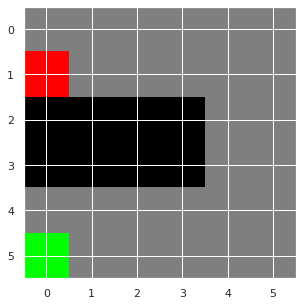

action 1
 0 - Up  /  1 - Down  /  2 - Left  / 3 - Right
reward -1.0
done False


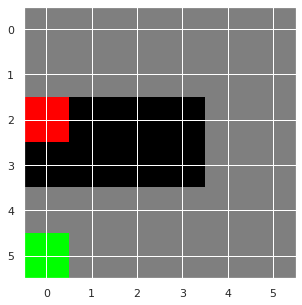

action 1
 0 - Up  /  1 - Down  /  2 - Left  / 3 - Right
reward -1.0
done False


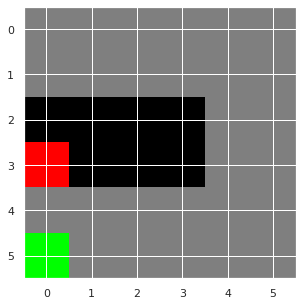

action 1
 0 - Up  /  1 - Down  /  2 - Left  / 3 - Right
reward 0.0
done False


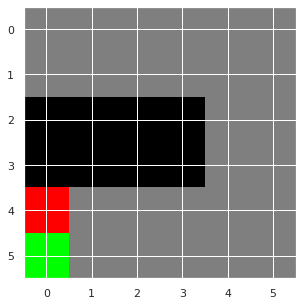

action 1
 0 - Up  /  1 - Down  /  2 - Left  / 3 - Right
reward 1.0
done True


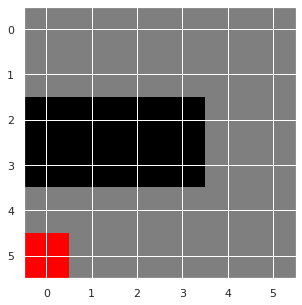

In [6]:

# param_env = {
#     "agent_pos":[0, 0], 
#     "goal_pos":[[9,0] ],
#     "reward_minmax":[-1.,1.],
#     "reward_pos":[[0, 0],[0, 1],[0, 2],[0, 3],[0, 4],[0, 5],[0, 6],[0, 7],[0, 8],[0, 9], 
#                   [1, 0],[1, 1],[1, 2],[1, 3],[1, 4],[1, 5],[1, 6],[1, 7],[1, 8],[1, 9], 
#                                                             [2, 6],[2, 7],[2, 8],[2, 9], 
#                                                             [3, 6],[3, 7],[3, 8],[3, 9], 
#                                                             [4, 6],[4, 7],[4, 8],[4, 9], 
#                                                             [5, 6],[5, 7],[5, 8],[5, 9], 
#                                                             [6, 6],[6, 7],[6, 8],[6, 9], 
#                                                             [7, 6],[7, 7],[7, 8],[7, 9], 
#                   [8, 0],[8, 1],[8, 2],[8, 3],[8, 4],[8, 5],[8, 6],[8, 7],[8, 8],[8, 9], 
#                   [9, 0],[9, 1],[9, 2],[9, 3],[9, 4],[9, 5],[9, 6],[9, 7],[9, 8],[9, 9]],
#     "grid_size" : 10,
#     "pattern": "empty",
# #     "pattern":["user_defined", [ [2,0],[2,1],[2,2],[2,3],[2,4],[2,5],
# #                                [7,0],[7,1],[7,2],[7,3],[7,4],[7,5]]],
#     "obs_mode":"index",
# }

param_env = {
    "agent_pos":[0, 0], 
    "goal_pos":[[5,0] ],
    "reward_minmax":[-1.,0.],
    "reward_user_defined":True,
    "reward_pos":[[0, 0],[0, 1],[0, 2],[0, 3],[0, 4],[0, 5], 
                  [1, 0],[1, 1],[1, 2],[1, 3],[1, 4],[1, 5], 
                                              [2, 4],[2, 5], 
                                              [3, 4],[3, 5], 
                  [4, 0],[4, 1],[4, 2],[4, 3],[4, 4],[4, 5], 
                  [5, 0],[5, 1],[5, 2],[5, 3],[5, 4],[5, 5]],
    "grid_size" : 6,
    "pattern": "empty",
    "obs_mode":"index",
}



env_name = "SimpleGrid"
env = custom_env(env_name, param_env)


param_agent = {
    "gamma": 0.90,
    "optimizer_LSFM": keras.optimizers.Adam(),
    "optimizer_Q": keras.optimizers.Adam(),
    "alpha_r" : 1.,
    "alpha_N" : 0.1,
    "alpha_psi" : 0.01,
    "policy": {
        "type": ["eps-greedy", "exponantial"],
        "eps-greedy": {
            "exponantial": {
                "eps_max": 1.,
                "eps_min": 0.01,
                "lambda": 0.0002
            },
            "constant": {
                "eps": 0.01
            }
        }
    },
    "memory" : 500000,
    "latent_space": 30,
    "num_episodes" : 100,
    "batch_size" : 32,
    "RANDOM_REWARD_STD" : -1.0, 
    "double_model" : True,
    "tau": 0.08,
    "filter_done" : True,
    "train_LSFM" : True,
    "train_on_Q_latent": True,
    "model_Q_Lin": True,
    "train" : True
}

agent = Agent(env, param_agent)


state = env.reset()
actions_down = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
for i in range(5) : 
    action = actions_down[i]
    next_state, reward, done, info = env.step(action)

    print("action", action)
    print(" 0 - Up  /  1 - Down  /  2 - Left  / 3 - Right")
#     print("next_state", next_state)
    print("reward", reward)
    print("done", done)
    env.render()
    
    state = next_state



In [7]:
def random_action(env) : 
    return random.randint(0, env.action_space.n - 1)

# models summary

## LSFM

Model: "model_LSFM"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 36)]         0                                            
__________________________________________________________________________________________________
hidden_latent (Dense)           (None, 30)           1110        input[0][0]                      
__________________________________________________________________________________________________
latent (Dense)                  (None, 30)           930         hidden_latent[0][0]              
__________________________________________________________________________________________________
Fa (Dense)                      (None, 120)          3600        latent[0][0]                     
_________________________________________________________________________________________

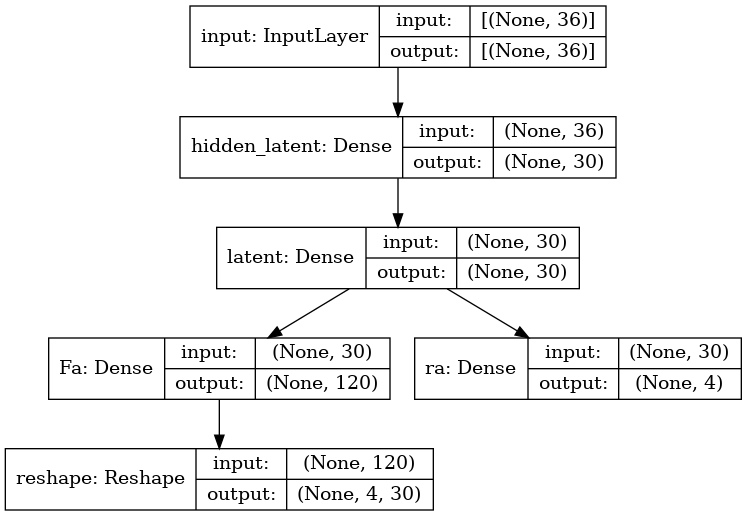

In [8]:
agent.model_LSFM.summary()
keras.utils.plot_model(agent.model_LSFM, "my_first_model.png", show_shapes=True)

## Linear QLearning
Qlearning on latent space

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (32, 30)                  1110      
_________________________________________________________________
dense_7 (Dense)              (32, 4)                   124       
Total params: 1,234
Trainable params: 1,234
Non-trainable params: 0
_________________________________________________________________


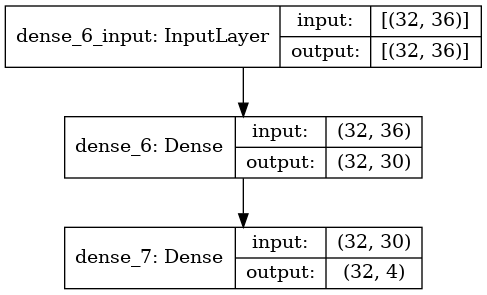

In [9]:
x= np.zeros((param_agent["batch_size"],env._state_dim), dtype=float)

agent_Q = Agent_Q(env, param_agent)
agent_Q.model_DQN(x)

agent_Q.model_DQN.summary()
keras.utils.plot_model(agent_Q.model_DQN, "my_first_model_Q.png", show_shapes=True)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (32, 30)                  930       
_________________________________________________________________
dense_9 (Dense)              (32, 4)                   124       
Total params: 1,054
Trainable params: 1,054
Non-trainable params: 0
_________________________________________________________________


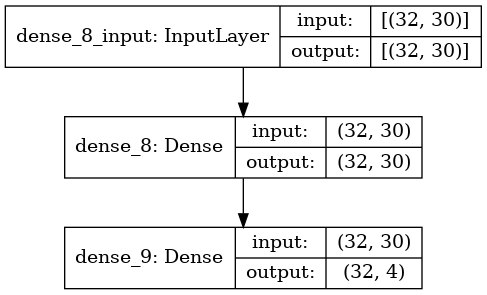

In [10]:
x= np.zeros((param_agent["batch_size"], param_agent["latent_space"] ), dtype=float)
agent_Q.model_DQN_latent(x)

agent_Q.model_DQN_latent.summary()
keras.utils.plot_model(agent_Q.model_DQN_latent, "my_first_model_Q.png", show_shapes=True)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (32, 4)                   144       
Total params: 144
Trainable params: 144
Non-trainable params: 0
_________________________________________________________________


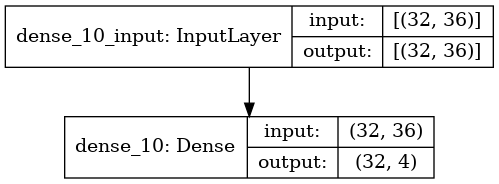

In [11]:
x= np.zeros((param_agent["batch_size"],env._state_dim), dtype=float)
agent_Q.model_LinQN(x)

agent_Q.model_LinQN.summary()
keras.utils.plot_model(agent_Q.model_LinQN, "my_first_model_QN.png", show_shapes=True)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (32, 4)                   144       
Total params: 144
Trainable params: 144
Non-trainable params: 0
_________________________________________________________________


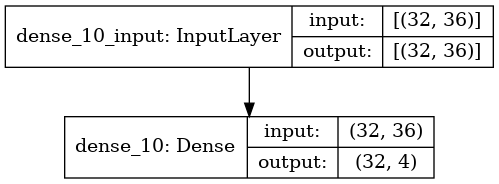

In [12]:
x= np.zeros((param_agent["batch_size"],env._state_dim), dtype=float)
agent_Q.model_LinQN(x)

agent_Q.model_LinQN.summary()
keras.utils.plot_model(agent_Q.model_LinQN, "my_first_model_QN.png", show_shapes=True)

# test 

In [13]:
states_double = np.array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.], 
                  [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0.]])
actions_double = np.array([0,1])

states = np.array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]])
actions = np.array([0])

states_2 = np.array([ 
                  [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0.]])
actions_2 = np.array([1])


# phi = agent.phi(states, agent.model_LSFM)
# phi

## reward 

In [14]:
phi = agent.model_LSFM(states_double)["phi"]
phi.shape

TensorShape([2, 30])

In [15]:
for idl, layer in enumerate(agent.model_LSFM.layers):
    name_a = "ra"
    if layer.name == name_a : 
        wa = layer.weights[0]
#         wa = tf.transpose(wa_transpose)

wa.shape

TensorShape([30, 4])

In [16]:
tf.matmul( phi , wa   )

<tf.Tensor: shape=(2, 4), dtype=float32, numpy=
array([[-0.00161126,  0.02376727, -0.06600967,  0.07853752],
       [ 0.12521604, -0.1413795 , -0.08119919,  0.10340405]],
      dtype=float32)>

In [17]:
agent.model_LSFM(states_double)["ra"] == tf.matmul( phi , wa   )

<tf.Tensor: shape=(2, 4), dtype=bool, numpy=
array([[ True,  True,  True,  True],
       [ True,  True,  True,  True]])>

## psi_bar


In [18]:
for idl, layer in enumerate(agent.model_LSFM.layers):
    name_a = "Fa"
    if layer.name == name_a :         
        Fa = layer.weights[0]

Fa.shape


TensorShape([30, 120])

In [19]:
Fa_reshape = tf.reshape(Fa, (Fa.shape[0],4,Fa.shape[0]))
Fa_reshape.shape

TensorShape([30, 4, 30])

In [20]:
phi = agent.model_LSFM(states_double)["phi"]
phi.shape

TensorShape([2, 30])

In [21]:
psi_batch = []

for b in range(2) : 
    phi_unique = tf.reshape(phi[b,:], (1,30))
    psi_unique = []
    for a in range(4) : 
        res = tf.matmul( phi_unique,Fa_reshape[:,a])
        res_reshape = tf.reshape(res, (30))
        psi_unique.append(res_reshape)
    psi_batch.append(psi_unique)
psi_scratch = tf.convert_to_tensor(psi_batch)

tf.norm(agent.model_LSFM(states_double)["Fa"]- psi_scratch, axis = 1)

<tf.Tensor: shape=(2, 30), dtype=float32, numpy=
array([[3.25962879e-09, 5.35004041e-09, 3.72529008e-09, 4.36828973e-09,
        4.26785585e-09, 1.49084356e-09, 1.05367111e-08, 1.31708888e-09,
        7.90253374e-09, 3.83994125e-09, 1.04125031e-09, 3.90295263e-09,
        3.60699670e-09, 2.67502021e-09, 4.92809571e-09, 3.22619598e-09,
        3.75428089e-09, 4.56252991e-09, 3.35793082e-09, 7.48325046e-09,
        3.35793082e-09, 5.89020122e-09, 4.60981120e-09, 4.26785585e-09,
        4.56252991e-09, 4.56252991e-09, 2.63417776e-09, 7.69398678e-09,
        7.56609975e-09, 5.26835553e-09],
       [7.67988251e-09, 8.78607942e-09, 9.12505982e-09, 3.07759471e-08,
        1.17804024e-08, 1.05367111e-08, 9.12505982e-09, 7.45058015e-09,
        1.20713199e-08, 3.07759471e-08, 7.95722244e-09, 8.53571169e-09,
        7.67988251e-09, 8.33000247e-09, 9.49766221e-09, 5.01532549e-09,
        1.31708888e-09, 2.71205192e-08, 6.24750207e-09, 1.53879736e-08,
        1.26330741e-08, 5.77870418e-09, 9.3132

## Fa_bar

In [22]:
Fa_bar = tf.math.reduce_mean(    Fa_reshape, axis=1 )
Fa_bar[:,:] == (Fa_reshape[:,0,:] + Fa_reshape[:,1,:] +Fa_reshape[:,2,:] +Fa_reshape[:,3,:] ) / 4
 
psi = agent.model_LSFM(states_double)["Fa"]

psi_bar = tf.math.reduce_mean(    psi, axis=1 )
psi_bar_scratch = tf.matmul( phi,Fa_bar)

tf.norm(psi_bar - psi_bar_scratch, axis = 0)
# Fa_reshape.mean()

<tf.Tensor: shape=(30,), dtype=float32, numpy=
array([3.8399413e-09, 2.0825006e-09, 7.4651183e-09, 8.3948271e-10,
       0.0000000e+00, 2.0825006e-09, 1.8626450e-09, 5.2683555e-09,
       5.4304965e-09, 1.8626450e-09, 0.0000000e+00, 2.5076627e-09,
       3.7542809e-09, 1.8626450e-09, 1.4725503e-09, 3.8399413e-09,
       1.8626450e-09, 4.1650012e-09, 8.3300025e-09, 4.0057695e-09,
       3.9786112e-09, 3.3579308e-09, 1.8626450e-09, 4.1650012e-09,
       0.0000000e+00, 5.6650142e-09, 5.8902012e-09, 3.7252903e-09,
       3.3579313e-09, 8.3300025e-09], dtype=float32)>

## filter 

In [23]:


terminate = [ True,  False]

filter_idxs = tf.dtypes.cast(tf.logical_not(terminate), tf.float32)


gamma = 0.9
gamma_psibar = tf.multiply(gamma,psi_bar)

filter_expand  = tf.transpose(tf.tile(
    tf.reshape(filter_idxs, (1,-1) ), [gamma_psibar.shape[1],1]
))


tf.math.multiply(filter_expand, gamma_psibar)

# tf.matmul( gamma_psibar,filter_expand)



<tf.Tensor: shape=(2, 30), dtype=float32, numpy=
array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        , -0.        ,  0.        ,  0.        ,
        -0.        , -0.        , -0.        , -0.        , -0.        ,
         0.        ,  0.        ,  0.        , -0.        , -0.        ,
        -0.        , -0.        ,  0.        ,  0.        , -0.        ,
         0.        , -0.        , -0.        , -0.        ,  0.        ],
       [ 0.01804004,  0.00043806,  0.02211758, -0.00613722, -0.0232616 ,
        -0.01645597,  0.0254419 , -0.0295538 , -0.00486518,  0.04054248,
        -0.019366  , -0.00098363,  0.01799057, -0.0216305 ,  0.00436319,
         0.0086106 ,  0.00331489,  0.0266325 , -0.03680964, -0.00647969,
         0.00719629, -0.00904442,  0.02155369,  0.01533739,  0.02282221,
        -0.00659893, -0.02662829, -0.04255011,  0.01158944,  0.03569445]],
      dtype=float32)>

# Train

In [24]:
print("steps : {}, episode : {}".format(0, 1))

steps : 0, episode : 1


In [25]:
def simu(env,param_agent,agent_LSFM, agent_Q = None) : 
    result_compile = []

    steps = 0
    render = param_agent["render"]

    reward_cumul = 0

    action_space = np.arange(env.action_space.n)
    possible_action = action_space

    
    memory = Memory(param_agent["memory"])
    memory_latent = Memory(param_agent["memory"])

    
    avg_loss = 0
    avg_loss_r  = 0
    avg_loss_N  = 0
    avg_loss_psi  = 0
    
    model_LSFM = agent_LSFM.model_LSFM
#     model_LSFM_prev= agent_LSFM.model_LSFM_prev
    if param_agent["train_LSFM"] == False : 
        if param_agent["train_on_Q_latent"] : 
            if param_agent["model_Q_Lin"] : 
                model_Q = agent_Q.model_LinQN_latent
                model_Q_prev = agent_Q.model_LinQN_latent_prev
                
                print("model Q is model_LinQN_latent_prev")
            else : 
                model_Q = agent_Q.model_DQN_latent
                model_Q_prev = agent_Q.model_DQN_latent_prev
                
                
                print("model Q is model_DQN_latent_prev")
        else : 
            if param_agent["model_Q_Lin"] : 
                model_Q = agent_Q.model_LinQN
                model_Q_prev = agent_Q.model_LinQN_prev
                
                print("model Q is model_LinQN_prev")
            else : 
                model_Q = agent_Q.model_DQN
                model_Q_prev = agent_Q.model_DQN_prev
                
                print("model Q is model_DQN_prev")
    
    for i in range(param_agent["num_episodes"]):
        state = env.reset()

        reward_ep_cumul = 0
        cnt = 0
        avg_loss = 0
        while True:
            if render:
                env.render()

            if param_agent["train_LSFM"] : 
                action, eps = agent_LSFM.choose_action_random()
                next_state, reward, done, info = env.step(action)
            else : 
                if param_agent["train_on_Q_latent"] : 
                    
                    state_resh = state.reshape(1,-1)
                    phi = agent_LSFM.model_LSFM(state_resh)["phi"]
                    state_latent = np.array(tf.reshape(phi, phi.shape[-1]))

                    # eps = MIN_EPSILON + (MAX_EPSILON - MIN_EPSILON) * math.exp(-LAMBDA * steps)
                                        
                    action, eps = agent_Q.choose_action(
                                        state_latent, 
                                        model_Q, 
                                        steps, 
                                        possible_action
                                    )
                    
                    next_state, reward, done, info = env.step(action)

                    next_state_resh = next_state.reshape(1,-1)
                    phi_prime = agent_LSFM.model_LSFM(next_state_resh)["phi"]
                    next_state_latent = np.array(tf.reshape(phi_prime, phi_prime.shape[-1]))

                    
                else : 
                # eps = MIN_EPSILON + (MAX_EPSILON - MIN_EPSILON) * math.exp(-LAMBDA * steps)
                    action, eps = agent_Q.choose_action(
                        state, 
                        model_Q, 
                        steps, 
                        possible_action
                    )

                    next_state, reward, done, info = env.step(action)


            if param_agent["RANDOM_REWARD_STD"] > 0:
                reward = np.random.normal(1.0, RANDOM_REWARD_STD)

            reward_ep_cumul += reward
            reward_cumul += reward
            
            if done:
                next_state = np.zeros(env._state_dim)
                next_state_latent = np.zeros(param_agent["latent_space"])
            
            
            
            if param_agent["train"] :
                if param_agent["train_LSFM"] : 
                    memory.add_sample((state, action, reward, next_state, done))
                    loss_all = agent_LSFM.train_LSFM(
                        model_LSFM, 
                        memory, 
                        param_agent["filter_done"])

                    avg_loss += loss_all[0]
                    avg_loss_r += loss_all[1]
                    avg_loss_N += loss_all[2]
                    avg_loss_psi += loss_all[3]
                else : 
                    if param_agent["train_on_Q_latent"] : 
                        memory_latent.add_sample((state_latent, action, reward, next_state_latent, done))

                        loss = agent_Q.train_Q(
                        model_Q, 
                        model_Q_prev if param_agent["double_model"] else None,
                        memory_latent, param_agent["filter_done"])
                        avg_loss += loss
                    else :                 
                        memory.add_sample((state, action, reward, next_state, done))

                        loss = agent_Q.train_Q(
                        model_Q, 
                        model_Q_prev if param_agent["double_model"] else None,
                        memory, param_agent["filter_done"])
                        avg_loss += loss
                
            state = next_state
        
            steps += 1
            if steps % 1000 == 0 : print("steps : {}, episode : {}, eps : {}".format(steps, i, eps))
#             print("steps : {}, episode : {}".format(steps, i))
            if done:
                
                if cnt != 0:
                    avg_loss /= cnt
                    avg_loss_r /= cnt
                    avg_loss_N /= cnt
                    avg_loss_psi /= cnt
                    
                else:
                    avg_loss = 0
                result = [i, cnt, steps, reward_ep_cumul,
                          reward_cumul, eps, avg_loss, avg_loss_r, avg_loss_N, avg_loss_psi]
                if i % 10  == 0 : print("Episode: {:03d}, step: {:03d}, cumul_step: {:04d}, Reward: {:3.1f}, Reward_cumul: {:3.1f}, eps: {:0.4f}, avg loss: {:0.4f}".format(*result))

                result_compile.append(result)
    #             with train_writer.as_default():
    #                 tf.summary.scalar('reward', cnt, step=i)
    #                 tf.summary.scalar('avg loss', avg_loss, step=i)
                break

            cnt += 1
    return result_compile
    
    


In [26]:
def plot_stat(data, param , col) : 
    stat = []
    stat_all = []
    for episode in range(param["num_episodes"]) : 

        mean = data.loc[lambda df: df['Episode'] == episode][col].mean()
        quantile10 = data.loc[lambda df: df['Episode'] == episode][col].quantile(0.1)
        quantile90 = data.loc[lambda df: df['Episode'] == episode][col].quantile(0.9)
        
        stat_all.append(data.loc[lambda df: df['Episode'] == episode][col].values   )

        stat.append([mean, quantile10, quantile90])
        
    data_stat = pd.DataFrame(stat, columns=[ "mean", "quantile10","quantile90"]     )
    


    # set seaborn style
    sns.set_theme()

    # Data
    x=range(param_agent_simu["num_episodes"])
    y=[ data_stat["quantile10"], data_stat["mean"], data_stat["quantile90"]]

    # Plot
    plt.stackplot(x,y, labels=['quantile10','mean','quantile90'])
    plt.legend(loc='upper left')
    plt.show()
    
    
    return data_stat, np.array(stat_all)

In [27]:
def box_plot(data,param, col) : 


    data_Q_episode_par_10 = pd.DataFrame()


    for k in range(0,param["num_episodes"], 10) : 
        data_Q_episode_par_10 = pd.concat([data_Q_episode_par_10,
                                          data.loc[lambda df: df['Episode'] == k]])


    fig, axs = plt.subplots(1, 1,figsize=(15, 5))
    sns.boxplot( x=data_Q_episode_par_10["Episode"], y=data_Q_episode_par_10[col] )
    
    return data_Q_episode_par_10

In [28]:
def carac_model(param) : 
    if param["train_LSFM"] : calcul = "LSFM"
    else : 
        if param["train_on_Q_latent"]  : calcul = "Q_latent"
        else : calcul = "Q"
        if param["model_Q_Lin"]  : calcul+="_Lin"
        else : calcul+="_Deep"
    
    return calcul

## Train LSFM on random policy

### train

In [29]:
param_agent = {
    "gamma": 0.90,
    "optimizer_LSFM": keras.optimizers.Adam(),
    "optimizer_Q": keras.optimizers.Adam(),
    "alpha_r" : 1.,
    "alpha_N" : 0.1,
    "alpha_psi" : 0.01,
    "policy": {
        "type": ["eps-greedy", "exponantial"],
        "eps-greedy": {
            "exponantial": {
                "eps_max": 1.,
                "eps_min": 0.01,
                "lambda": 0.0005
            },
            "constant": {
                "eps": 0.01
            }
        }
    },
    "memory" : 500000,
    "latent_space": 30,
    "num_episodes" : 200,
    "batch_size" : 32,
    "RANDOM_REWARD_STD" : -1.0, 
    "double_model" : True,
    "tau": 0.08,
    "filter_done" : True,
    "train_LSFM" : True,
    "train_on_Q_latent": True,
    "model_Q_Lin": True,
    "train" : True,
    "render": False,
    "reset_Q_model": False,
     "reset_LSFM" : False,
    "run": 15,
    
}

In [30]:
# %%time


# from itertools import product


# param_agent_simu = {}
# param_agent_simu = param_agent.copy()
# param_agent_simu["run"] = 10
# param_agent_simu["double_model"] = False




# params = {
#     "alpha_N" : [1e-2,1e-1, 1e0],
#     "alpha_psi" : [1e-2, 1e-1, 1e0]
# #     "alpha_N" : [1e-1],
# #     "alpha_psi" : [1e-2]
# }
# combi_params = [dict(zip(params, v)) for v in product(*params.values())]

# results = []

# data_LSFM = pd.DataFrame()

# for params in combi_params : 
    
        
    
#     for key, value in params.items():
#         param_agent_simu[key] = value
    
#     for k in range(param_agent_simu["run"]) : 
#         param_agent_simu["reset_LSFM"] = True
        
        
#         agent = Agent(env, param_agent_simu)

#         result_compile = simu(env,param_agent_simu,agent) 
        
#         data_train_df = pd.DataFrame(result_compile, columns=[ 
#         "Episode", 
#         "Step", 
#         "cum_step",
#         "Reward", 
#         "Reward_cum",
#         "Eps",  
#         "Avg_loss" ,  
#         "Avg_loss_r",  
#         "Avg_loss_N",  
#         "Avg_loss_psi"])



#         data_train_df["carac"] = carac_model(param_agent_simu) 
#         data_train_df["param"] = str(params)    
#         data_LSFM = pd.concat([data_LSFM, data_train_df])

#         eval_step = int(param_agent_simu["num_episodes"] - param_agent_simu["num_episodes"] /10)

        

#         avg_loss = data_train_df.loc[eval_step:,"Avg_loss"].mean()
#         avg_loss_r = data_train_df.loc[eval_step:,"Avg_loss_r"].mean()
#         avg_loss_N = data_train_df.loc[eval_step:,"Avg_loss_N"].mean()
#         avg_loss_psi = data_train_df.loc[eval_step:,"Avg_loss_psi"].mean()

#         print("avg_loss", avg_loss)
#         print("avg_loss_r", avg_loss_r)
#         print("avg_loss_N", avg_loss_N)
#         print("avg_loss_psi", avg_loss_psi)

#         results.append([avg_loss,avg_loss_r, avg_loss_N,avg_loss_psi , str(params)   ])
    

# results


# # data_results = pd.DataFrame(results, columns=[ "Avg_loss", "Avg_loss_r","Avg_loss_N", "Avg_loss_psi", params ]     )

### eval the error on random sequence action

In [31]:
# results = [[3.176959758045183e-05,
#   2.798083355495293e-05,
#   1.8875659346196596e-05,
#   0.0003884338938202283,
#   "{'alpha_N': 0.01, 'alpha_psi': 0.01}"],
#  [4.8884972492475486e-05,
#   4.2541213621542396e-05,
#   3.5208295764644505e-05,
#   0.0007129369574973769,
#   "{'alpha_N': 0.01, 'alpha_psi': 0.01}"],
#  [3.464046493115672e-05,
#   2.527707237780832e-05,
#   2.550882040988037e-05,
#   0.001043851466359858,
#   "{'alpha_N': 0.01, 'alpha_psi': 0.01}"],
#  [2.5550009224490483e-05,
#   2.1217015884888853e-05,
#   1.98769202516294e-05,
#   0.0004555757851310496,
#   "{'alpha_N': 0.01, 'alpha_psi': 0.01}"],
#  [2.8447343880421365e-05,
#   2.196239187718853e-05,
#   2.144160222404527e-05,
#   0.0006803511764699953,
#   "{'alpha_N': 0.01, 'alpha_psi': 0.01}"],
#  [2.9093045833676346e-05,
#   2.1357312640220443e-05,
#   2.1698517801684723e-05,
#   0.0007855017287279151,
#   "{'alpha_N': 0.01, 'alpha_psi': 0.01}"],
#  [3.3130845200072903e-05,
#   2.2972594953577943e-05,
#   1.85029824916625e-05,
#   0.0010652871122968635,
#   "{'alpha_N': 0.01, 'alpha_psi': 0.01}"],
#  [3.948526118770918e-05,
#   2.7193661616471355e-05,
#   2.553463000528891e-05,
#   0.0012429719253192735,
#   "{'alpha_N': 0.01, 'alpha_psi': 0.01}"],
#  [3.422338473180242e-05,
#   2.871294602212402e-05,
#   2.4339846638234243e-05,
#   0.0006246352270925147,
#   "{'alpha_N': 0.01, 'alpha_psi': 0.01}"],
#  [3.717520847379691e-05,
#   3.113054260616087e-05,
#   2.2880063388150324e-05,
#   0.0006441582120076925,
#   "{'alpha_N': 0.01, 'alpha_psi': 0.01}"],
#  [6.52864756302688e-05,
#   3.725289569072417e-05,
#   3.720898450932436e-05,
#   0.0002832007729730925,
#   "{'alpha_N': 0.01, 'alpha_psi': 0.1}"],
#  [5.101970446536484e-05,
#   2.7613140535364218e-05,
#   3.4322052856015505e-05,
#   0.0002513989606079645,
#   "{'alpha_N': 0.01, 'alpha_psi': 0.1}"],
#  [7.709987175685648e-05,
#   3.1201638917941836e-05,
#   5.277315327120332e-05,
#   0.0004628295568060908,
#   "{'alpha_N': 0.01, 'alpha_psi': 0.1}"],
#  [7.076793844861253e-05,
#   3.7390472608602074e-05,
#   5.794195677115393e-05,
#   0.00034192669566876374,
#   "{'alpha_N': 0.01, 'alpha_psi': 0.1}"],
#  [6.346093784901297e-05,
#   3.282703831315166e-05,
#   5.033679044178081e-05,
#   0.0003134830434619762,
#   "{'alpha_N': 0.01, 'alpha_psi': 0.1}"],
#  [5.385581950363593e-05,
#   2.9201698490858917e-05,
#   2.2504818220310882e-05,
#   0.00025148274826416117,
#   "{'alpha_N': 0.01, 'alpha_psi': 0.1}"],
#  [8.815392506436782e-05,
#   3.67629265135954e-05,
#   3.590629692676378e-05,
#   0.0005250349952855157,
#   "{'alpha_N': 0.01, 'alpha_psi': 0.1}"],
#  [7.346414575348087e-05,
#   3.840453380156711e-05,
#   4.7613229111842826e-05,
#   0.00037104784172715055,
#   "{'alpha_N': 0.01, 'alpha_psi': 0.1}"],
#  [9.308967194056943e-05,
#   2.4404848937462363e-05,
#   6.568275687766854e-05,
#   0.0007029586218939849,
#   "{'alpha_N': 0.01, 'alpha_psi': 0.1}"],
#  [9.324558707031239e-05,
#   3.477862938005002e-05,
#   3.375284445833689e-05,
#   0.0005921072777911917,
#   "{'alpha_N': 0.01, 'alpha_psi': 0.1}"],
#  [0.28654758553224624,
#   0.003815033716421197,
#   14.932313917242217,
#   0.137514640165708,
#   "{'alpha_N': 0.01, 'alpha_psi': 1.0}"],
#  [0.1375300085088097,
#   0.0022218251446129915,
#   7.809552325751673,
#   0.061217443090467394,
#   "{'alpha_N': 0.01, 'alpha_psi': 1.0}"],
#  [0.07070487038612328,
#   0.002879446447658162,
#   3.809394216802443,
#   0.030617901358206447,
#   "{'alpha_N': 0.01, 'alpha_psi': 1.0}"],
#  [0.24856614073186684,
#   0.009875844802900352,
#   14.499701155805045,
#   0.10387328352355599,
#   "{'alpha_N': 0.01, 'alpha_psi': 1.0}"],
#  [3.9312211759564795,
#   0.027277407997172765,
#   249.56283762473376,
#   1.48283116946356,
#   "{'alpha_N': 0.01, 'alpha_psi': 1.0}"],
#  [0.08772798291038397,
#   0.0021088188583843794,
#   4.078964644297516,
#   0.045522715871792505,
#   "{'alpha_N': 0.01, 'alpha_psi': 1.0}"],
#  [0.11356054768410022,
#   0.0033031051747832696,
#   6.6955202470576385,
#   0.04496221637571584,
#   "{'alpha_N': 0.01, 'alpha_psi': 1.0}"],
#  [0.024748072987035016,
#   0.0005010728558932448,
#   1.2727548231093893,
#   0.011883795847254863,
#   "{'alpha_N': 0.01, 'alpha_psi': 1.0}"],
#  [0.6662927972557047,
#   0.006920361779779183,
#   41.12313570791496,
#   0.25502948688445864,
#   "{'alpha_N': 0.01, 'alpha_psi': 1.0}"],
#  [2.4660490142021603,
#   0.019711229342777352,
#   176.0566222595935,
#   0.754686266896764,
#   "{'alpha_N': 0.01, 'alpha_psi': 1.0}"],
#  [2.881647043866401e-05,
#   1.9820339128776974e-05,
#   8.513623513396363e-06,
#   0.0008635796502339971,
#   "{'alpha_N': 0.1, 'alpha_psi': 0.01}"],
#  [4.2722639199476506e-05,
#   3.277616012075487e-05,
#   1.0370234316033816e-05,
#   0.0010134457933051672,
#   "{'alpha_N': 0.1, 'alpha_psi': 0.01}"],
#  [4.415230844960317e-05,
#   2.8590263572884278e-05,
#   1.1662369829904962e-05,
#   0.0014866312682929807,
#   "{'alpha_N': 0.1, 'alpha_psi': 0.01}"],
#  [3.737975349878301e-05,
#   3.06783683927371e-05,
#   1.2063061562231913e-05,
#   0.0006280583713087943,
#   "{'alpha_N': 0.1, 'alpha_psi': 0.01}"],
#  [3.6787226870784676e-05,
#   2.1983455547099056e-05,
#   8.48946169210556e-06,
#   0.0014435815940087924,
#   "{'alpha_N': 0.1, 'alpha_psi': 0.01}"],
#  [4.4343857431642186e-05,
#   3.228787588485694e-05,
#   1.2325955713715e-05,
#   0.001208144071242383,
#   "{'alpha_N': 0.1, 'alpha_psi': 0.01}"],
#  [4.249449430987399e-05,
#   3.6348946025146896e-05,
#   1.1017720783669243e-05,
#   0.0005668697084253852,
#   "{'alpha_N': 0.1, 'alpha_psi': 0.01}"],
#  [2.8245040395478024e-05,
#   1.922908566912168e-05,
#   8.316381701958457e-06,
#   0.0008509210365383844,
#   "{'alpha_N': 0.1, 'alpha_psi': 0.01}"],
#  [3.575858039519737e-05,
#   2.7063217413534592e-05,
#   1.2405134808477465e-05,
#   0.0007912937102055936,
#   "{'alpha_N': 0.1, 'alpha_psi': 0.01}"],
#  [3.598561113744051e-05,
#   2.8881291412928514e-05,
#   1.43901463138736e-05,
#   0.0006609573735877019,
#   "{'alpha_N': 0.1, 'alpha_psi': 0.01}"],
#  [5.6612268334074733e-05,
#   3.0357995900993496e-05,
#   1.3404449974826294e-05,
#   0.0002555337012664302,
#   "{'alpha_N': 0.1, 'alpha_psi': 0.1}"],
#  [9.599180928075959e-05,
#   3.195574675119656e-05,
#   1.2165975515105552e-05,
#   0.0006471840763685745,
#   "{'alpha_N': 0.1, 'alpha_psi': 0.1}"],
#  [6.10875779823452e-05,
#   2.532197793727354e-05,
#   1.1858445591488512e-05,
#   0.00035860801292259394,
#   "{'alpha_N': 0.1, 'alpha_psi': 0.1}"],
#  [0.00012703329449637908,
#   3.504553722521507e-05,
#   1.7711195342374556e-05,
#   0.000933045484700817,
#   "{'alpha_N': 0.1, 'alpha_psi': 0.1}"],
#  [6.660248395427181e-05,
#   3.304567923545569e-05,
#   1.3167597955093183e-05,
#   0.00033629997237149113,
#   "{'alpha_N': 0.1, 'alpha_psi': 0.1}"],
#  [0.000113665320757566,
#   2.5352868683759508e-05,
#   1.1425712885011429e-05,
#   0.0008989897371340953,
#   "{'alpha_N': 0.1, 'alpha_psi': 0.1}"],
#  [4.53799931099205e-05,
#   2.135338665862016e-05,
#   9.784442308159664e-06,
#   0.00023606495942259283,
#   "{'alpha_N': 0.1, 'alpha_psi': 0.1}"],
#  [8.016729430046064e-05,
#   4.640489790479639e-05,
#   1.8755824861636798e-05,
#   0.0003360907946084017,
#   "{'alpha_N': 0.1, 'alpha_psi': 0.1}"],
#  [5.7032520051838946e-05,
#   2.4129857133400354e-05,
#   9.859936633891711e-06,
#   0.00032700812503505647,
#   "{'alpha_N': 0.1, 'alpha_psi': 0.1}"],
#  [4.112306830569268e-05,
#   2.4723000340371554e-05,
#   9.96492266961476e-06,
#   0.00016128931224837715,
#   "{'alpha_N': 0.1, 'alpha_psi': 0.1}"],
#  [0.01211942646324359,
#   0.00028471348578670163,
#   0.04986248950564971,
#   0.00697620534132552,
#   "{'alpha_N': 0.1, 'alpha_psi': 1.0}"],
#  [0.0026843853311440914,
#   8.846795376525925e-05,
#   0.0016581608141117258,
#   0.002469876079076888,
#   "{'alpha_N': 0.1, 'alpha_psi': 1.0}"],
#  [0.007085966865627627,
#   0.00017792505899211805,
#   0.012918740104094367,
#   0.00582830547519682,
#   "{'alpha_N': 0.1, 'alpha_psi': 1.0}"],
#  [0.0040222707604701926,
#   0.00014867547187448368,
#   0.004944405619049266,
#   0.0034973572789600152,
#   "{'alpha_N': 0.1, 'alpha_psi': 1.0}"],
#  [0.010946695625658183,
#   0.000364904348072361,
#   0.024827556384167067,
#   0.008296436293958698,
#   "{'alpha_N': 0.1, 'alpha_psi': 1.0}"],
#  [0.0026930807114850176,
#   0.00015633178086269222,
#   0.002167676638371473,
#   0.002363299071196065,
#   "{'alpha_N': 0.1, 'alpha_psi': 1.0}"],
#  [0.01598305434437261,
#   0.0004512546551352859,
#   0.061459068673031636,
#   0.009518789783122698,
#   "{'alpha_N': 0.1, 'alpha_psi': 1.0}"],
#  [0.0037217139725991936,
#   0.0002574863029629899,
#   0.003128893718646438,
#   0.003191322524861204,
#   "{'alpha_N': 0.1, 'alpha_psi': 1.0}"],
#  [0.0026870804390382876,
#   0.000203792540317672,
#   0.002309238773388395,
#   0.0022958197907789937,
#   "{'alpha_N': 0.1, 'alpha_psi': 1.0}"],
#  [0.0035648704236392473,
#   0.0001820728831642426,
#   0.005566655406999034,
#   0.0029003081578680254,
#   "{'alpha_N': 0.1, 'alpha_psi': 1.0}"],
#  [3.8667069354083173e-05,
#   2.3823230756280304e-05,
#   8.101114082872805e-06,
#   0.0007284180982897868,
#   "{'alpha_N': 1.0, 'alpha_psi': 0.01}"],
#  [2.999281257904857e-05,
#   2.0312796720917496e-05,
#   6.674153959903623e-06,
#   0.00033038487899563726,
#   "{'alpha_N': 1.0, 'alpha_psi': 0.01}"],
#  [3.857167016533772e-05,
#   2.2209853593714094e-05,
#   6.688520808049372e-06,
#   0.0010496358600429,
#   "{'alpha_N': 1.0, 'alpha_psi': 0.01}"],
#  [3.29156082391203e-05,
#   2.0034494733513784e-05,
#   7.57728426999535e-06,
#   0.0006024092448449209,
#   "{'alpha_N': 1.0, 'alpha_psi': 0.01}"],
#  [2.9666278722722254e-05,
#   1.814610034285708e-05,
#   6.599684301182347e-06,
#   0.0005312275883646522,
#   "{'alpha_N': 1.0, 'alpha_psi': 0.01}"],
#  [4.195798251692887e-05,
#   2.8316689277421934e-05,
#   8.279190943635242e-06,
#   0.0006238058554663728,
#   "{'alpha_N': 1.0, 'alpha_psi': 0.01}"],
#  [2.628575898075719e-05,
#   1.5546121741506355e-05,
#   5.658745268473508e-06,
#   0.0005372404288595177,
#   "{'alpha_N': 1.0, 'alpha_psi': 0.01}"],
#  [3.433251459221897e-05,
#   2.259500738875881e-05,
#   7.896018709604653e-06,
#   0.0004454218528588583,
#   "{'alpha_N': 1.0, 'alpha_psi': 0.01}"],
#  [3.370595543337309e-05,
#   2.2260230522160534e-05,
#   7.4632018101096005e-06,
#   0.0004646377243538124,
#   "{'alpha_N': 1.0, 'alpha_psi': 0.01}"],
#  [3.1095658724893276e-05,
#   2.0160734321067183e-05,
#   6.004906863210881e-06,
#   0.0005581066361840274,
#   "{'alpha_N': 1.0, 'alpha_psi': 0.01}"],
#  [4.826063051966067e-05,
#   2.1878201926374713e-05,
#   7.870608946146138e-06,
#   0.0001944645016502291,
#   "{'alpha_N': 1.0, 'alpha_psi': 0.1}"],
#  [5.935360572241952e-05,
#   2.636343165933324e-05,
#   9.923148605943418e-06,
#   0.00024929234185695266,
#   "{'alpha_N': 1.0, 'alpha_psi': 0.1}"],
#  [6.65114018948972e-05,
#   2.553594516342752e-05,
#   7.32905388022987e-06,
#   0.00034583647728885744,
#   "{'alpha_N': 1.0, 'alpha_psi': 0.1}"],
#  [5.617132404841622e-05,
#   2.4472656706182285e-05,
#   8.031797728269831e-06,
#   0.00024818177394511203,
#   "{'alpha_N': 1.0, 'alpha_psi': 0.1}"],
#  [5.0264443665410114e-05,
#   2.296431542282729e-05,
#   7.737824550920327e-06,
#   0.00020447333990280397,
#   "{'alpha_N': 1.0, 'alpha_psi': 0.1}"],
#  [5.957807127608687e-05,
#   2.8845043037557322e-05,
#   9.594733709157197e-06,
#   0.00022535184133128588,
#   "{'alpha_N': 1.0, 'alpha_psi': 0.1}"],
#  [6.424275106512603e-05,
#   2.2591462651720707e-05,
#   6.359174800398199e-06,
#   0.00036608998517234794,
#   "{'alpha_N': 1.0, 'alpha_psi': 0.1}"],
#  [5.6300362684908615e-05,
#   2.1302928387034035e-05,
#   7.440077943891242e-06,
#   0.00028537629325416585,
#   "{'alpha_N': 1.0, 'alpha_psi': 0.1}"],
#  [7.648040766907535e-05,
#   2.158935139269033e-05,
#   7.13468214411341e-06,
#   0.0004945688249824865,
#   "{'alpha_N': 1.0, 'alpha_psi': 0.1}"],
#  [4.850978205392804e-05,
#   1.6770904024945998e-05,
#   6.11373313541304e-06,
#   0.0002627915943725481,
#   "{'alpha_N': 1.0, 'alpha_psi': 0.1}"],
#  [0.000141667697251407,
#   2.5200620444911518e-05,
#   1.5278453442390178e-05,
#   0.00010413121806983896,
#   "{'alpha_N': 1.0, 'alpha_psi': 1.0}"],
#  [0.00017621572638902209,
#   2.5521598214266157e-05,
#   1.1315809266870382e-05,
#   0.0001418513644754345,
#   "{'alpha_N': 1.0, 'alpha_psi': 1.0}"],
#  [0.00016592680403420586,
#   2.0967515354843e-05,
#   1.0615509188401127e-05,
#   0.00013754596725971827,
#   "{'alpha_N': 1.0, 'alpha_psi': 1.0}"],
#  [0.00014628857910578075,
#   2.5021998323726214e-05,
#   9.839630294712792e-06,
#   0.00011314860736258284,
#   "{'alpha_N': 1.0, 'alpha_psi': 1.0}"],
#  [0.00015792126272914142,
#   2.8299323550847343e-05,
#   1.544555039648625e-05,
#   0.00011974550681940427,
#   "{'alpha_N': 1.0, 'alpha_psi': 1.0}"],
#  [0.00016080980572864283,
#   2.3932286707604835e-05,
#   9.445997562742533e-06,
#   0.00012980475069630486,
#   "{'alpha_N': 1.0, 'alpha_psi': 1.0}"],
#  [0.0002766759620771564,
#   2.806441175603661e-05,
#   1.1436490448442928e-05,
#   0.00024252233270083404,
#   "{'alpha_N': 1.0, 'alpha_psi': 1.0}"],
#  [0.0001860023970367141,
#   2.474639820860709e-05,
#   1.300370728380896e-05,
#   0.00015084293728003065,
#   "{'alpha_N': 1.0, 'alpha_psi': 1.0}"],
#  [0.00016120976172051164,
#   2.6619584250933458e-05,
#   1.087386717002719e-05,
#   0.0001265347718196023,
#   "{'alpha_N': 1.0, 'alpha_psi': 1.0}"],
#  [0.0002163590952307733,
#   2.4562426432382867e-05,
#   1.1764842807586456e-05,
#   0.00018370386434648887,
#   "{'alpha_N': 1.0, 'alpha_psi': 1.0}"]]

In [32]:
# data_results = pd.DataFrame(results, columns=[ "Avg_loss", "Avg_loss_r","Avg_loss_N", "Avg_loss_psi", "params" ]     )

In [33]:
# data_results = pd.DataFrame(results, columns=[ "Avg_loss", "Avg_loss_r","Avg_loss_N", "Avg_loss_psi", "params" ]     )
# col = "Avg_loss"
# df = data_results
# fig, axs = plt.subplots(1, 1,figsize=(10, 5))
# sns.boxplot( x=df["params"], y=df[col] )
# axs.set_xticklabels(df["params"].unique(),  rotation=30, ha= 'right');
# plt.ylim(0, 0.0001)

### train LSFM on best parameters

In [34]:
# data_LSFM.to_csv('data_LSFM.csv')

In [35]:
# data_results.to_csv('data_results.csv')

In [ ]:
%%time


from itertools import product


param_agent_simu = {}
param_agent_simu = param_agent.copy()
param_agent_simu["run"] = 1
param_agent_simu["double_model"] = False

params = {
#     "alpha_N" : [1e-1, 1e0],
#     "alpha_psi" : [1e-2, 1e-1, 1e0]
    "alpha_N" : [1e0],
    "alpha_psi" : [1e-2]
}
combi_params = [dict(zip(params, v)) for v in product(*params.values())]

results_best = []

data_LSFM_best = pd.DataFrame()

for params in combi_params : 
    
        
    
    for key, value in params.items():
        param_agent_simu[key] = value
    
    for k in range(param_agent_simu["run"]) : 
        param_agent_simu["reset_LSFM"] = True
        
        
        
        agent = Agent(env, param_agent_simu)
        result_compile = simu(env,param_agent_simu,agent) 
        
        data_train_df = pd.DataFrame(result_compile, columns=[ 
        "Episode", 
        "Step", 
        "cum_step",
        "Reward", 
        "Reward_cum",
        "Eps",  
        "Avg_loss" ,  
        "Avg_loss_r",  
        "Avg_loss_N",  
        "Avg_loss_psi"])



        data_train_df["carac"] = carac_model(param_agent_simu) 
        data_train_df["param"] = str(params)    
        data_LSFM_best = pd.concat([data_LSFM_best, data_train_df])

        eval_step = int(param_agent_simu["num_episodes"] - param_agent_simu["num_episodes"] /10)

        
        
        
        
        fig, axs = plt.subplots(2, 3,figsize=(15, 10))
        plt.figure(figsize=(5, 5))
        sns.lineplot(x="cum_step", y="Avg_loss", data=data_train_df, ax = axs[0,0] )
        sns.lineplot(x="cum_step", y="Avg_loss_r", data=data_train_df, ax = axs[0,1] )
        sns.lineplot(x="cum_step", y="Avg_loss_N", data=data_train_df, ax = axs[0,2] )
        sns.lineplot(x="cum_step", y="Avg_loss_psi", data=data_train_df, ax = axs[1,0] )
        plt.show()

        avg_loss = data_train_df.loc[eval_step:,"Avg_loss"].mean()
        avg_loss_r = data_train_df.loc[eval_step:,"Avg_loss_r"].mean()
        avg_loss_N = data_train_df.loc[eval_step:,"Avg_loss_N"].mean()
        avg_loss_psi = data_train_df.loc[eval_step:,"Avg_loss_psi"].mean()

        print("avg_loss", avg_loss)
        print("avg_loss_r", avg_loss_r)
        print("avg_loss_N", avg_loss_N)
        print("avg_loss_psi", avg_loss_psi)

        results_best.append([avg_loss,avg_loss_r, avg_loss_N,avg_loss_psi , str(params)   ])
    

results_best

Episode: 000, step: 098, cumul_step: 0099, Reward: -17.0, Reward_cumul: -17.0, eps: 1.0000, avg loss: 0.0237
steps : 1000, episode : 8, eps : 1.0
Episode: 010, step: 036, cumul_step: 1271, Reward: -3.0, Reward_cumul: -269.0, eps: 1.0000, avg loss: 0.0009
steps : 2000, episode : 13, eps : 1.0
steps : 3000, episode : 20, eps : 1.0
Episode: 020, step: 622, cumul_step: 3352, Reward: -92.0, Reward_cumul: -747.0, eps: 1.0000, avg loss: 0.0001
steps : 4000, episode : 21, eps : 1.0
steps : 5000, episode : 24, eps : 1.0
steps : 6000, episode : 28, eps : 1.0
Episode: 030, step: 149, cumul_step: 6644, Reward: -34.0, Reward_cumul: -1379.0, eps: 1.0000, avg loss: 0.0001
steps : 7000, episode : 31, eps : 1.0
steps : 8000, episode : 38, eps : 1.0
Episode: 040, step: 067, cumul_step: 8109, Reward: -30.0, Reward_cumul: -1678.0, eps: 1.0000, avg loss: 0.0000
steps : 9000, episode : 47, eps : 1.0
Episode: 050, step: 086, cumul_step: 9486, Reward: -26.0, Reward_cumul: -1937.0, eps: 1.0000, avg loss: 0.000

In [ ]:
plt.figure(figsize=(5, 5))
sns.lineplot(x="cum_step", y="Avg_loss", data=data_train_df, label="Avg_loss" )
sns.lineplot(x="cum_step", y="Avg_loss_r", data=data_train_df, label="Avg_loss_r" )
sns.lineplot(x="cum_step", y="Avg_loss_N", data=data_train_df , label="Avg_loss_N")
sns.lineplot(x="cum_step", y="Avg_loss_psi", data=data_train_df , label="Avg_loss_psi")
plt.legend()
plt.show()

In [ ]:
# data_results = pd.DataFrame(results, columns=[ "Avg_loss", "Avg_loss_r","Avg_loss_N", "Avg_loss_psi", "params" ]     )
# col = "Avg_loss"
# df = data_results
# fig, axs = plt.subplots(1, 1,figsize=(10, 5))
# sns.boxplot( x=df["params"], y=df[col] )
# axs.set_xticklabels(df["params"].unique(),  rotation=30, ha= 'right');

## Q-learning

In [ ]:
param_agent_simu = {}
param_agent_simu = param_agent.copy()

param_agent_simu["train_LSFM"] = False
param_agent_simu["double_model"] = True
param_agent_simu["train_on_Q_latent"] = True
param_agent_simu["model_Q_Lin"] = True
param_agent_simu["policy"]["eps-greedy"]["exponantial"]["lambda"]=0.0005

param_agent_simu["reset_LSFM"] =  False
param_agent_simu["reset_Q_model"] =  True
param_agent_simu["run"] =  15

In [ ]:
param_agent_simu

### Linear latent Q-learning 


 Train Q-function on __latent reward-predictive state space__ and on the _optimal policy_ to _maximize the dicounted sum of rewards_

In [ ]:
%%time
param_agent_simu = {}
param_agent_simu = param_agent.copy()

param_agent_simu["train_LSFM"] = False
param_agent_simu["double_model"] = True
param_agent_simu["train_on_Q_latent"] = True
param_agent_simu["model_Q_Lin"] = True
param_agent_simu["policy"]["eps-greedy"]["exponantial"]["lambda"]=0.0005

param_agent_simu["reset_Q_model"] =  False
param_agent_simu["run"] =  15

param_agent_simu["reset_LSFM"] =  False

data = pd.DataFrame()

for k in range(param_agent_simu["run"]) : 
    agent_Q = Agent_Q(env, param_agent)
    
    result_compile = simu(env,param_agent_simu, agent, agent_Q)
    data_train_df = pd.DataFrame(result_compile, columns=[ 
    "Episode", 
    "Step", 
    "cum_step",
    "Reward", 
    "Reward_cum",
    "Eps",  
    "Avg_loss" ,  
    "Avg_loss_r",  
    "Avg_loss_N",  
    "Avg_loss_psi"])

    data_train_df["carac"] = carac_model(param_agent_simu) 
    data_train_df["run"] = k
    data = pd.concat([data, data_train_df])

data_Q_lat_state  = data.copy()
    

In [ ]:
data_stat, stat_all = plot_stat(data, param_agent_simu , "Reward_cum")
box_plot(data, param_agent_simu, "Reward_cum")

In [ ]:
data

### Linear Q-learning  --- original state

In [ ]:
%%time
param_agent_simu = {}
param_agent_simu = param_agent.copy()

param_agent_simu["policy"]["type"] = ["eps-greedy", "exponantial"]
param_agent_simu["double_model"] = True
param_agent_simu["train_LSFM"] = False
param_agent_simu["train_on_Q_latent"] = False
param_agent_simu["model_Q_Lin"] = True
param_agent_simu["policy"]["eps-greedy"]["exponantial"]["lambda"]=0.0005

param_agent_simu["reset_Q_model"] =  False

data = pd.DataFrame()

for k in range(10) : 
    agent_Q = Agent_Q(env, param_agent)

    result_compile = simu(env,param_agent_simu, agent, agent_Q)
    data_train_df = pd.DataFrame(result_compile, columns=[ 
    "Episode", 
    "Step", 
    "cum_step",
    "Reward", 
    "Reward_cum",
    "Eps",  
    "Avg_loss" ,  
    "Avg_loss_r",  
    "Avg_loss_N",  
    "Avg_loss_psi"])

    data_train_df["carac"] = carac_model(param_agent_simu) 
    data_train_df["run"] = k
    data = pd.concat([data, data_train_df])
    
data_Q_or_state  = data.copy()

In [ ]:
data_stat, stat_all = plot_stat(data, param_agent_simu , "Reward_cum")
box_plot(data, param_agent_simu , "Reward_cum")

### Deep Q-learning  --- original state

In [ ]:
%%time

param_agent_simu = param_agent.copy()

param_agent_simu["policy"]["type"] = ["eps-greedy", "exponantial"]
param_agent_simu["double_model"] = True
param_agent_simu["train_LSFM"] = False
param_agent_simu["train_on_Q_latent"] = False
param_agent_simu["model_Q_Lin"] = False
param_agent_simu["policy"]["eps-greedy"]["exponantial"]["lambda"]=0.0005

param_agent_simu["reset_Q_model"] =  False

for k in range(10) : 
    agent_Q = Agent_Q(env, param_agent)

    result_compile = simu(env,param_agent_simu, agent, agent_Q)
    data_train_df = pd.DataFrame(result_compile, columns=[ 
    "Episode", 
    "Step", 
    "cum_step",
    "Reward", 
    "Reward_cum",
    "Eps",  
    "Avg_loss" ,  
    "Avg_loss_r",  
    "Avg_loss_N",  
    "Avg_loss_psi"])

    data_train_df["carac"] = carac_model(param_agent_simu) 
    data_train_df["run"] = k
    data = pd.concat([data, data_train_df])
    
    

data_Deep_or_state  = data.copy()
    
# fig, axs = plt.subplots(2, 3,figsize=(15, 10))

# sns.lineplot(x="cum_step", y="Reward_cum", data=data_train_df, ax = axs[0,0] )
# sns.lineplot(x="cum_step", y="Reward", data=data_train_df, ax = axs[0,1] )
# sns.lineplot(x="cum_step", y="Avg_loss", data=data_train_df, ax = axs[0,2] )
# sns.lineplot(x="cum_step", y="Eps", data=data_train_df, ax = axs[1,0] )

In [ ]:
data_stat, stat_all = plot_stat(data, param_agent_simu , "Reward_cum")
box_plot(data, param_agent_simu, "Reward_cum")


# results

## compile results

In [ ]:
data_Q_lat_state

In [ ]:
fig, axs = plt.subplots(2, 3,figsize=(15, 10))

sns.lineplot(x="cum_step", y="Reward_cum", data=data_train_df, ax = axs[0,0] )
sns.lineplot(x="cum_step", y="Reward", data=data_train_df, ax = axs[0,1] )
sns.lineplot(x="cum_step", y="Avg_loss", data=data_train_df, ax = axs[0,2] )
sns.lineplot(x="cum_step", y="Eps", data=data_train_df, ax = axs[1,0] )

## See results

In [ ]:
# data_Q_or_state.loc[lambda df: df['Episode'] == 0]

* Filter_done must be activate even for the learning of the LSFM model

In [ ]:
# param_agent_simu = {}
# param_agent_simu = param_agent.copy()
# param_agent_simu["train_LSFM"] = False
# param_agent_simu["train_on_Q_latent"] = False
# param_agent_simu["model_Q_Lin"] = False
# param_agent_simu["num_episodes"] = 1
# param_agent_simu["policy"]["type"] = ["eps-greedy", "constant"]
# param_agent_simu["policy"]["eps-greedy"]["constant"]["eps"]=0.00
# param_agent_simu["train"]=False
# param_agent_simu["render"]=True
# simu(env,param_agent_simu,agent)


In [ ]:

# data_see_df = pd.DataFrame(result_compile, columns=[ "Episode", "Step", "cum_step", "Reward", "Reward_cum", "Avg_loss", "Eps"])


# data_see_df.to_csv('data_see_df.csv', sep='\t', encoding='utf-8')


# import matplotlib.pyplot as plt

# fig, axs = plt.subplots(2, 3,figsize=(15, 10))


# plt.figure(figsize=(5, 5))
# sns.lineplot(x="cum_step", y="Reward_cum", data=data_see_df, ax = axs[0,0] )
# sns.lineplot(x="cum_step", y="Reward", data=data_see_df, ax = axs[0,1] )
# sns.lineplot(x="cum_step", y="Avg_loss", data=data_see_df, ax = axs[0,2] )
# sns.lineplot(x="cum_step", y="Eps", data=data_see_df, ax = axs[1,0] )

In [ ]:
# env.close()